### **One Node Runtime Validation**

In [1]:
from langgraph.graph import StateGraph, START, END 
from pydantic import BaseModel 

class OverallState(BaseModel):
    a : str 

def node(state: OverallState):
    return {"a": "Hi my name is Hitesh!"}

In [2]:
builder = StateGraph(OverallState)
builder.add_node(node) 
builder.add_edge(START, "node") 
builder.add_edge("node", END) 
graph = builder.compile() 

In [3]:
graph.invoke({"a": "Hello"})

{'a': 'Hi my name is Hitesh!'}

In [5]:
try:
    graph.invoke({"a": 20})
except Exception as e:
    print("Exception was raised because a value of type int was passed")

Exception was raised because a value of type int was passed


### **Multi Node Runtime Validation**

In [6]:
from langgraph.graph import StateGraph, START, END 
from typing import TypedDict 
from pydantic import BaseModel 

class OverallState(BaseModel):
    a: str 

def bad_node(state: OverallState):
    return {
        "a": 123 # Invalid
        }

def ok_node(state: OverallState):
    return {
        "a" : "Good" 
    }

In [10]:
builer = StateGraph(OverallState)
builder.add_node(bad_node) 
builder.add_node(ok_node) 
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END) 
graph = builder.compile() 

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [12]:
try:
    graph.invoke({"a": "Hitesh"}) 
except Exception as e:
    print("Exception was raised because of invalid state") 
    print(e)


Exception was raised because of invalid state
At key 'a': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


### **Prompt Chaining**

In [13]:
from typing import TypedDict 
from langgraph.graph import StateGraph, START, END 
from IPython.display import Image, display 
 
class State(TypedDict):
    topic: str 
    joke: str 
    improved_joke: str 
    final_joke: str

In [50]:
from langchain_openai import ChatOpenAI 
import os 
from dotenv import load_dotenv 
load_dotenv() 

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini")

In [51]:
def generate_joke(state: State):
    """Generate a joke about the topic""" 
    joke = llm.invoke(f"Write a short joke about {state["topic"]}")
    return {"joke": joke.content}  

In [75]:
def check_punchline(state: State):
    """Check if the joke has a punchline"""
    if state["joke"].endswith("?") or state["joke"].endswith("!"):
        return "Pass"
    return "Failed" 

In [76]:
def improve_joke(state: State):
    """Improve the joke with wordplay""" 
    improved_joke = llm.invoke(f"Improve the joke with wordplay: {state["joke"]}") 
    return {"improved_joke": improved_joke.content} 

In [77]:
def polish_joke(state: State):
    """Add surprising twist to the joke"""  
    final_joke = llm.invoke(f"Add surprising twist to the joke: {state["improved_joke"]}") 
    return {"final_joke": final_joke.content}


In [78]:
# Build the workflow  
workflow = StateGraph(State) 

# Workflow nodes  
workflow.add_node("generate_joke", generate_joke) 
workflow.add_node("improve_joke", improve_joke) 
workflow.add_node("polish_joke", polish_joke)

# Workflow edges  
workflow.add_edge(START, "generate_joke") 
workflow.add_conditional_edges("generate_joke", check_punchline, {"Failed": "improve_joke", "Pass": END}) 
workflow.add_edge("improve_joke", "polish_joke") 
workflow.add_edge("polish_joke", END) 

In [79]:
graph = workflow.compile()

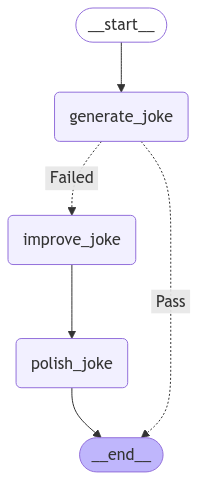

In [80]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [81]:
state = graph.invoke({"topic": "Hello?"})

In [85]:
for i, j in state.items():
    print(j)

Hello?
Why did the phone go to therapy?

Because it couldn't stop saying, "Hello? Can you hear me now?"
Why did the phone go to therapy? 

Because it couldn't stop having "call" issues and kept saying, "Hello? Can you hear me dial-ing for help?"
Why did the phone go to therapy?

Because it couldn't stop having "call" issues and kept saying, "Hello? Can you hear me dial-ing for help?" 

But then, during a breakthrough session, it revealed: "I don't just want to be a smartphone—I want to be a smart **person**!" Turns out, it was just trying to connect on a deeper level!
